In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import skew, kurtosis

In [355]:

# Load the data
patient_id = 33

df = pd.read_csv(rf"D:\University\Aalto\Project_course\Dataset\db1bcg\s{patient_id}.csv")

# Define categories of columns
metadata_cols = ['Age', 'Height', 'Weight', 'Gender', 'CF_dist', 'fs']
pulse_wave_cols = ['tonc_mean', 'tonf_mean', 'bcg_mean']
beatwise_cols = ['RR', 'HR', 'pattonc', 'pattonf', 'ptt_cf', 'RI', 'RJ', 'RK', 'IJ', 'AI', 'AJ', 'AK']

# Extract metadata (first row only for subject info)
metadata_df = df.loc[0, metadata_cols].to_frame().T
metadata_df.reset_index(drop=True, inplace=True)

# Extract beat-wise parameters (these appear to be on each row)
beatwise_df = df[beatwise_cols].copy()
#the data frame has NAN values up untill the 600th row, we dont need these NaN values so lets drop them
beatwise_df.dropna(subset=['RR'], inplace=True)

# Fill NaN values in beat-wise parameters (if any)
#beatwise_df.fillna(method='ffill', inplace=True)

# Extract pulse wave signals
pulse_wave_df = df[pulse_wave_cols].copy()


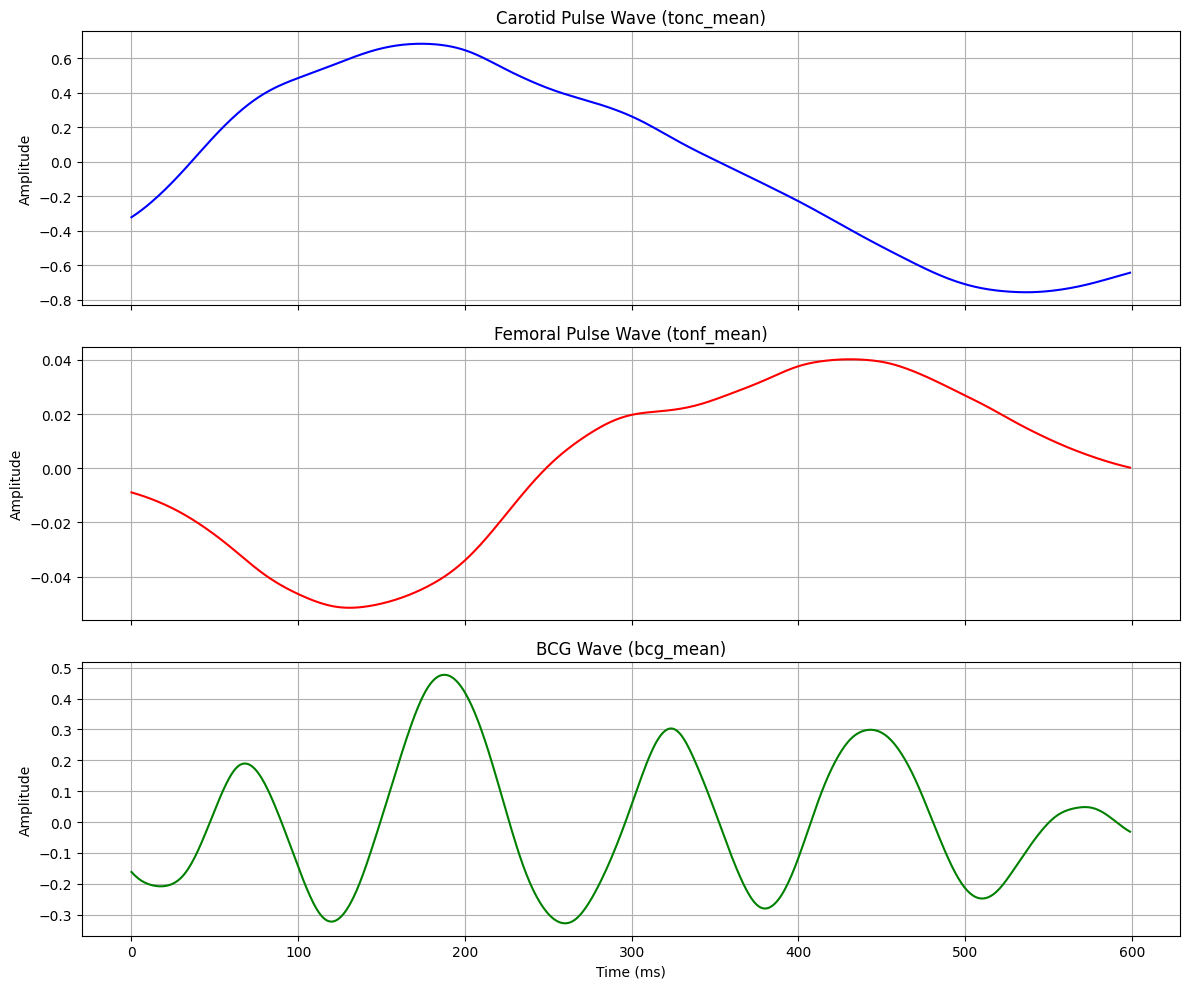

Sampling frequency: 1000.0 Hz
Number of samples in pulse waves: 600
Duration of pulse waves: 0.60 seconds (600.0 ms)


In [356]:
# Extract metadata (first row only for subject info)
metadata_df = df.loc[0, metadata_cols].to_frame().T
metadata_df.reset_index(drop=True, inplace=True)

# Extract beat-wise parameters
beatwise_df = df[beatwise_cols].copy()
beatwise_df.dropna(subset=['RR'], inplace=True)

# Extract pulse wave signals
pulse_wave_df = df[pulse_wave_cols].copy()

# Get sampling frequency
fs = metadata_df['fs'].iloc[0]

# Create time vector for pulse wave signals (assuming 600ms window as mentioned in your description)
time_ms = np.arange(0, len(pulse_wave_df)) * (1000/fs)  # Convert to milliseconds

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot tonc_mean
ax1.plot(time_ms, pulse_wave_df['tonc_mean'], 'b-')
ax1.set_title('Carotid Pulse Wave (tonc_mean)')
ax1.set_ylabel('Amplitude')
ax1.grid(True)

# Plot tonf_mean
ax2.plot(time_ms, pulse_wave_df['tonf_mean'], 'r-')
ax2.set_title('Femoral Pulse Wave (tonf_mean)')
ax2.set_ylabel('Amplitude')
ax2.grid(True)
    
# Plot bcg_mean
ax3.plot(time_ms, pulse_wave_df['bcg_mean'], 'g-')
ax3.set_title('BCG Wave (bcg_mean)')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Amplitude')
ax3.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print some basic info about the pulse waves
print(f"Sampling frequency: {fs} Hz")
print(f"Number of samples in pulse waves: {len(pulse_wave_df)}")
print(f"Duration of pulse waves: {len(pulse_wave_df)/fs:.2f} seconds ({len(pulse_wave_df)/fs*1000:.1f} ms)")

In [357]:
print(beatwise_df.head())

print(beatwise_df.tail())

       RR       HR  pattonc  pattonf  ptt_cf     RI     RJ     RK    IJ  \
0  2013.0  29.8063     89.0    427.0   338.0  112.0  187.0  374.0  75.0   
1  1229.0  48.8202    -21.0    191.0   212.0   64.0  131.0  327.0  67.0   
2  1858.0  32.2928    -98.0    275.0   373.0   72.0  142.0  456.0  70.0   
3  1414.0  42.4328    -60.0    211.0   271.0  160.0  228.0  418.0  68.0   
4  1101.0  54.4959   -162.0     66.0   228.0    0.0    0.0    0.0   0.0   

        AI       AJ       AK  
0 -0.29847  0.46461 -0.30893  
1 -0.37179  0.46125 -0.23490  
2 -0.26813  0.42010 -0.28682  
3 -0.30712  0.47670 -0.35245  
4  0.00000  0.00000  0.00000  
        RR        HR  pattonc  pattonf  ptt_cf    RI     RJ     RK    IJ  \
11   193.0  310.8808    558.0     76.0  -482.0   0.0    0.0    0.0   0.0   
12   915.0   65.5738    551.0    147.0  -404.0  68.0  141.0  445.0  73.0   
13   567.0  105.8201      NaN      NaN     NaN   NaN    NaN    NaN   NaN   
14  1313.0   45.6969      NaN      NaN     NaN   NaN    NaN

# Beatwise
We have some anaomalies in the data, so we need to check each of the beat wise columns and remove the anomalies, this is done using the IQR method, also we are not deleting the row that contains the anamoly for all the columns, just for the cell containing the anamaly, that we we preserve as much data as possible


In [358]:
def remove_outliers_iqr_column_wise(df, columns, iqr_multiplier=3.0):
    """
    Applies IQR-based outlier removal for each column independently by setting outliers to np.nan.
    Also returns a dictionary of IQRs per column.
    """
    import numpy as np
    cleaned_df = df.copy()
    iqr_dict = {}

    for col in columns:
        if col not in cleaned_df.columns:
            print(f"Warning: Column '{col}' not found in dataframe. Skipping.")
            continue
        
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        iqr_dict[col] = IQR

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        cleaned_df.loc[
            (cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound), col
        ] = np.nan

    return cleaned_df, iqr_dict

beatwise_df_no_anomalies, iqr_dict = remove_outliers_iqr_column_wise(beatwise_df, beatwise_cols)


Saving patient data into three seperate files, metadata, beatwise data and ensemble data before calculating the statics for the beatwise data, that way we have copies of the cleaned data if we need to use them again in the future


In [359]:
# Base output path
base_path = r"D:\University\Aalto\Project_course\CleanedData"

# Create subfolders if they don't exist
os.makedirs(os.path.join(base_path, "metadata"), exist_ok=True)
os.makedirs(os.path.join(base_path, "beats"), exist_ok=True)
os.makedirs(os.path.join(base_path, "ensemble"), exist_ok=True)

# File paths using patient ID
metadata_path = os.path.join(base_path, "metadata", f"metadata_{patient_id}.csv")
beats_path = os.path.join(base_path, "beats", f"beats_data_{patient_id}.csv")
ensemble_path = os.path.join(base_path, "ensemble", f"ensemble_data_{patient_id}.csv")

# Save each file
metadata_df.to_csv(metadata_path, index=False)
beatwise_df_no_anomalies.to_csv(beats_path, index=False)
pulse_wave_df.to_csv(ensemble_path, index=False)

print(f"✔️ Saved files for patient {patient_id}:")
print(f"   - Metadata → {metadata_path}")
print(f"   - Beatwise → {beats_path}")
print(f"   - Ensemble → {ensemble_path}")


✔️ Saved files for patient 33:
   - Metadata → D:\University\Aalto\Project_course\CleanedData\metadata\metadata_33.csv
   - Beatwise → D:\University\Aalto\Project_course\CleanedData\beats\beats_data_33.csv
   - Ensemble → D:\University\Aalto\Project_course\CleanedData\ensemble\ensemble_data_33.csv


# Create summary statistics for beatwise data

In [360]:
def summarize_column(series):
    """Compute summary statistics for a single column (ignores NaNs)."""
    s = series.dropna()
    if len(s) == 0:
        return {
            'mean': np.nan,
            'std': np.nan,
            'min': np.nan,
            'max': np.nan,
            'range': np.nan,
            'median': np.nan,
            'skew': np.nan,
            'kurtosis': np.nan,
            'count': 0,
        }
    return {
        'mean': s.mean(),
        'std': s.std(),
        'min': s.min(),
        'max': s.max(),
        'range': s.max() - s.min(),
        'median': s.median(),
        'skew': skew(s),
        'kurtosis': kurtosis(s),
        'count': s.count(),
    }

 Adding Heart-Rate Variability (HRV) metrics 


In [361]:
def add_hrv_metrics(summary_dict, rr_intervals):
    """Add HRV features from RR series."""
    import numpy as np

    clean_rr = np.array(rr_intervals.dropna())

    if len(clean_rr) < 2:
        # Not enough RR data
        summary_dict['RR_SDNN'] = np.nan
        summary_dict['RR_RMSSD'] = np.nan
        summary_dict['RR_SDSD'] = np.nan
        summary_dict['RR_pNN50'] = np.nan
        summary_dict['RR_pNN20'] = np.nan
        summary_dict['HR_mean'] = np.nan
        summary_dict['HR_std'] = np.nan
        summary_dict['RR_CV'] = np.nan
        return summary_dict

    rr_diffs = np.diff(clean_rr)

    summary_dict['RR_SDNN'] = np.std(clean_rr)
    summary_dict['RR_RMSSD'] = np.sqrt(np.mean(rr_diffs**2))
    summary_dict['RR_SDSD'] = np.std(rr_diffs)
    summary_dict['RR_pNN50'] = 100 * np.sum(np.abs(rr_diffs) > 50) / len(rr_diffs)
    summary_dict['RR_pNN20'] = 100 * np.sum(np.abs(rr_diffs) > 20) / len(rr_diffs)

    hr = 60000 / clean_rr
    

    summary_dict['RR_CV'] = 100 * (np.std(clean_rr) / np.mean(clean_rr))

    return summary_dict





In [362]:
def summarize_beatwise_df(df, iqr_dict=None, patient_id=None):
    feature_dict = {}

    for col in df.columns:
        stats = summarize_column(df[col])
        for stat_name, value in stats.items():
            feature_dict[f"{col}_{stat_name}"] = value
        if iqr_dict and col in iqr_dict:
            feature_dict[f"{col}_iqr"] = iqr_dict[col]

    # Add HRV metrics using RR column
    if "RR" in df.columns:
        feature_dict = add_hrv_metrics(feature_dict, df["RR"])

    if patient_id is not None:
        feature_dict["patient_id"] = patient_id

    return pd.DataFrame([feature_dict])


beatwise_features_df = summarize_beatwise_df(beatwise_df_no_anomalies, iqr_dict=iqr_dict, patient_id=patient_id)


In [363]:
# Ensure the 'features' folder exists
os.makedirs(os.path.join(base_path, "features"), exist_ok=True)

# Add patient_id to both DataFrames
metadata_df.insert(0, "patient_id", patient_id)
beatwise_features_df["patient_id"] = patient_id

# Merge: metadata first, then features (excluding duplicate patient_id)
combined_df = pd.concat([metadata_df, beatwise_features_df.drop(columns=["patient_id"])], axis=1)

# Reorder: just in case
cols = ["patient_id"] + [col for col in combined_df.columns if col != "patient_id"]
combined_df = combined_df[cols]

# Save path
features_output_path = os.path.join(base_path, "features", "all_patient_features.csv")

# Save or append
if os.path.exists(features_output_path):
    combined_df.to_csv(features_output_path, mode='a', index=False, header=False)
else:
    combined_df.to_csv(features_output_path, mode='w', index=False, header=True)

print(f"✔️ Appended combined metadata + features for patient {patient_id} to:")
print(f"   {features_output_path}")


✔️ Appended combined metadata + features for patient 33 to:
   D:\University\Aalto\Project_course\CleanedData\features\all_patient_features.csv
